## Librosa wrapper

In [55]:
import librosa
import numpy as np
from scipy import signal
from scipy.io import wavfile


SAMPLE_RATE = 8000
TARGET_DURATION = 8000
# MFCC method required DCT filters, define these up here for later reuse.
dct_filters = librosa.filters.dct(40, 40)


def log_spectrogram_signal(wav, sample_rate=SAMPLE_RATE, window_size=20, step_size=10, eps=1e-10):
    """
    A function that loads a wav file and converts it into a log spectrogram representation using
    scipy's signal.
    :param wav: File path to a wav file.
    :param sample_rate: The sample rate of the original file.
    :param window_size:
    :param step_size:
    :param eps: Small value to avoid NaN issues.
    :return: A Log Spectrogram.
    """
    audio = wavfile.read(wav)[1]

    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    if audio.size < TARGET_DURATION:
        audio = np.pad(audio, (TARGET_DURATION - audio.size, 0), mode='constant')
    elif audio.size > TARGET_DURATION:
        audio = audio[0:TARGET_DURATION]

    _, _, spec = signal.spectrogram(audio, fs=sample_rate,
                                    window='hann', nperseg=nperseg,
                                    noverlap=noverlap, detrend=False)

    log_spec = np.log(spec.T.astype(np.float32) + eps)
    log_spec = log_spec.reshape(log_spec.shape[0], log_spec.shape[1], 1)
    return log_spec


def log_spectrogram(audio, sample_rate=SAMPLE_RATE, window_size=20, step_size=10, eps=1e-6):
    """
    Creates a log spectrogram using librosa rather than signal.
    :param audio: A list of floating point values representing a wav file.
    :param sample_rate: The sample rate of the original file.
    :param window_size:
    :param step_size:
    :param eps: Small value to avoid NaN issues.
    :return: A log Spectrogram
    """
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    D = librosa.stft(audio, n_fft=nperseg, hop_length=noverlap, win_length=nperseg, window='hann')
    spectrogram = librosa.magphase(D)[0]
    log_spectrogram = np.log(spectrogram.astype(np.float32) + eps)
    return log_spectrogram.reshape(log_spectrogram.shape[0], log_spectrogram.shape[1], 1)


def log_mel_spectrogram(audio, sample_rate=SAMPLE_RATE, n_mels=40, n_fft=480, normalize=False):
    """
    Creates a log mel spectrogram representation of the audio.
    :param audio: A list of floating point values representing a wav file.
    :param sample_rate: The sample rate of the original file.
    :param n_mels:
    :param n_fft:
    :param normalize:
    :return: A log mel spectrogram
    """
    mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate, n_mels=n_mels, hop_length=160, n_fft=n_fft, fmin=20, fmax=4000)
    mel_spec[mel_spec > 0] = np.log(mel_spec[mel_spec > 0])
    if normalize:
        mel_spec -= (np.mean(mel_spec, axis=0) + 1e-8)

    return mel_spec.reshape(mel_spec.shape[0], mel_spec.shape[1], 1)


def load_audio(audio):
    """
    Takes raw audio and performs normalisation.
    :param audio: A list of floating point values representing a wav file.
    :return: audio: Raw audio array.
    """
    # Normalize the audio.
    audio = (audio - np.mean(audio)) / np.std(audio)
    return audio.reshape(-1, 1)


def mfcc(audio, sample_rate=SAMPLE_RATE, n_mels=40, n_fft=400, normalize=True):
    """
    Creates an MFCC (Mel-frequency cepstral coefficients) representation of an audio file.
    :param audio:
    :param sample_rate:
    :param n_mels:
    :param n_fft:
    :param normalize:
    :return: A MFCC representation of the audio.
    """
    mfcc = librosa.feature.melspectrogram(audio, sr=sample_rate, n_mels=n_mels, hop_length=160, n_fft=n_fft, fmin=20, fmax=40000)
    mfcc[mfcc > 0] = np.log(mfcc[mfcc > 0])
    mfcc = [np.matmul(dct_filters, x) for x in np.split(mfcc, mfcc.shape[1], axis=1)]
    mfcc = np.array(mfcc, order="F").squeeze(2).astype(np.float32)

    if normalize:
        mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

    return mfcc.reshape(mfcc.shape[0], mfcc.shape[1], 1)

In [42]:
from scipy.fftpack import dct
from librosa.feature import delta, spectral_bandwidth, poly_features, mfcc
from sklearn.preprocessing import scale
N, low, high, M = 0, 300, 800, 200
F = 0

def meller(x):
    return 1127 * np.log(1 + x / 700)

def antimeller(x):
    return 700 * (np.exp(x / 1127) - 1)

#def f(m):
#    return M / antimeller(meller(high) - meller(low)) * antimeller(meller(low) + m / (M + 1) * (meller(high) - meller(low)))

def prep_F():
    global F
    samplerate = (meller(high) - meller(low)) / M
    F = antimeller(np.linspace(meller(low), meller(high), M + 1)) / samplerate
    #F = np.floor(f / samplerate)

def windows(k, m):
    if (k < F[m - 1] or k > F[m + 1]):
        return 0
    if (F[m - 1] <= k < F[m]):
        return (k - F[m - 1]) / (F[m] - F[m - 1])
    return (F[m + 1] - k) / (F[m + 1] - F[m])

def H(m):
    return np.array([windows(i, m) for i in range(N)])

def prepare(X):
    X = np.fft.fft(X)
    global N
    N = len(X[0])
    prep_F()
    print(F)
    i = np.where(H(20) != 0)
    print(i, H(1))
    S = np.array([np.log(X @ H(m)) for m in range(1, M)]).T
    print(S)
    return np.abs(dct(S))

def mfcc_apply(x):
    #print(spectral_centroid(x), spectral_centroid(x).shape)
    #x -= spectral_centroid(x, sr = 8000, )
    #x = log_mel_spectrogram(x, normalize=True).flatten()
    #mfcc_ = mfcc(x, n_mels = 160).flatten()
    #x -= (np.mean(x, axis=0) + 1e-8)
    mfcc_ = mfcc(y = x, sr = 8000)
    mfcc_delta = delta(mfcc_)
    return mfcc_

def prep_top(X):
    X = (X - np.mean(X, axis = 0)) / np.std(X)
    return np.array([mfcc_apply(x) for x in X]).reshape(len(X), 400)

## Upload and plot data

(1000, 10000)
(1000, 400)


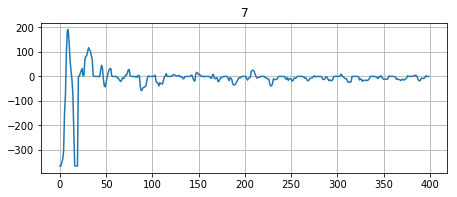

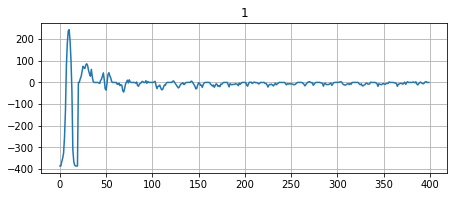

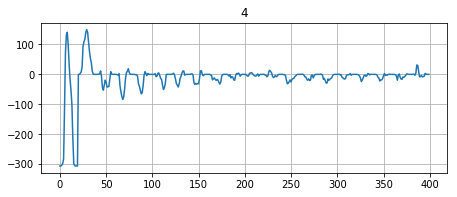

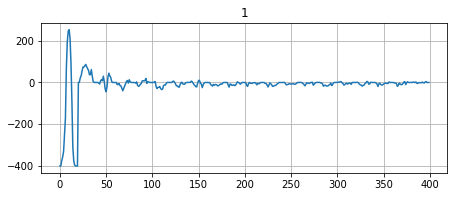

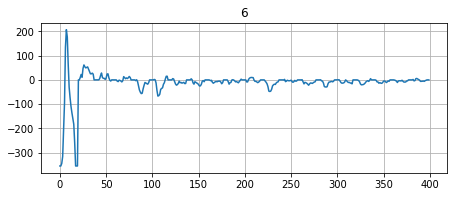

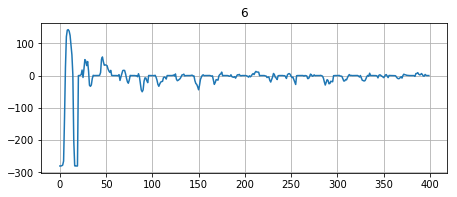

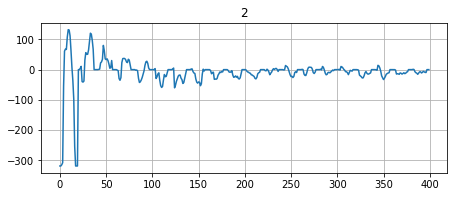

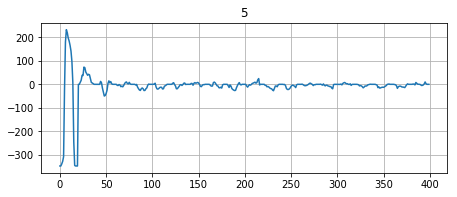

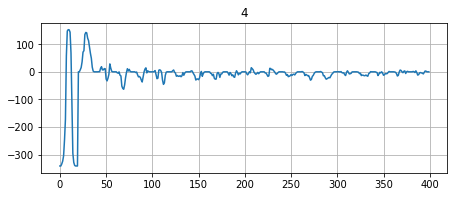

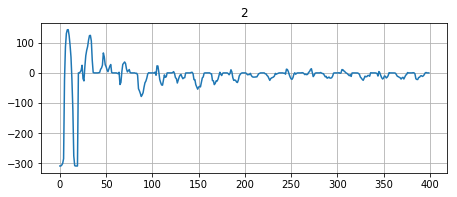

In [43]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load('x_train.npy')
Y = np.load('y_train.npy')
print(X.shape)
X = prep_top(X)
print(X.shape)

for i in range(10):
    plt.figure(figsize=(16, 16))
    plt.subplot(5, 2, i + 1)
    plt.title(Y[i])
    plt.plot(X[i])
    plt.grid()
    plt.show()

## Train xgboost classifier on gpu

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np
import time
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, )

skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(X, Y)
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    num_round = 100
    #param = {'objective': 'multi:softmax', # Specify multiclass classification
    #     'num_class': 10, # Number of possible output classes
    #     'tree_method': 'gpu_exact',
    #     'max_bin' : 32
    #     }
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 0
    param['nthread'] = 4
    param['num_class'] = 10
    param['tree_method'] = 'gpu_hist'
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    gpu_res = {} # Store accuracy result
    tmp = time.time()
    # Train model
    model = xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
    print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))
    y_pred = model.predict(dtest)
    print(accuracy_score(y_test, y_pred))

[0]	test-merror:0.223108
[1]	test-merror:0.167331
[2]	test-merror:0.153386
[3]	test-merror:0.139442
[4]	test-merror:0.121514
[5]	test-merror:0.11753
[6]	test-merror:0.115538
[7]	test-merror:0.103586
[8]	test-merror:0.099602
[9]	test-merror:0.09761
[10]	test-merror:0.093626
[11]	test-merror:0.091633
[12]	test-merror:0.081673
[13]	test-merror:0.079681
[14]	test-merror:0.079681
[15]	test-merror:0.079681
[16]	test-merror:0.077689
[17]	test-merror:0.077689
[18]	test-merror:0.073705
[19]	test-merror:0.075697
[20]	test-merror:0.073705
[21]	test-merror:0.071713
[22]	test-merror:0.069721
[23]	test-merror:0.069721
[24]	test-merror:0.067729
[25]	test-merror:0.067729
[26]	test-merror:0.065737
[27]	test-merror:0.063745
[28]	test-merror:0.063745
[29]	test-merror:0.063745
[30]	test-merror:0.063745
[31]	test-merror:0.065737
[32]	test-merror:0.063745
[33]	test-merror:0.063745
[34]	test-merror:0.063745
[35]	test-merror:0.061753
[36]	test-merror:0.061753
[37]	test-merror:0.061753
[38]	test-merror:0.06374

In [19]:
def saver(path, res):
    with open(path, 'w') as out:
        print('Id,Label', file = out)
        for i in range(len(res)):
            print('{i},{res}'.format(i = i + 1, res=int(res[i])), file = out)

In [34]:
import xgboost as xgb
import numpy as np
import time

X_train = np.load('x_train.npy')
X_train = prep_top(X_train)
y_train = np.load('y_train.npy')
X_test = np.load('x_test.npy')
X_test = prep_top(X_test)

num_round = 162
param = {}
    # use softmax multi-class classification
param['objective'] = 'multi:softmax'
    # scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 0
param['nthread'] = 4
param['num_class'] = 10
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

tmp = time.time()
model = xgb.train(param, dtrain, num_round)
model.save_model('mfcc5.md')
print("GPU Training Time: %s seconds" % (str((time.time() - tmp))))
y_pred = model.predict(dtest)
saver('mfcc5.csv', y_pred)

GPU Training Time: 18.553041219711304 seconds


In [47]:
import pandas as pd
c = np.array(pd.read_csv('mfcc1.csv')['Label'])
d = np.array(pd.read_csv('mfcc2.csv')['Label'])
e = np.array(pd.read_csv('mfcc3.csv')['Label'])
g = np.array(pd.read_csv('mfcc4.csv')['Label'])
f = np.array(pd.read_csv('mfcc5.csv')['Label'])
res = []
for i in range(len(c)):
    res.append(np.argmax(np.bincount([c[i], d[i], e[i], g[i], f[i]])))
res = np.array(res)
print(res)
saver('averag.csv', res)

[9 2 6 2 6 6 1 3 2 9 1 0 6 2 8 3 3 7 1 6 4 1 5 0 7 8 7 2 4 2 8 3 7 5 3 9 8
 0 5 6 6 2 0 6 7 8 2 4 1 1 4 4 6 8 0 3 9 8 1 1 2 6 0 9 5 9 5 4 5 9 8 3 2 3
 0 9 0 9 0 0 3 4 1 0 5 5 3 6 1 1 5 2 0 8 0 8 0 4 3 8 4 3 8 2 8 3 2 6 5 9 7
 2 8 8 8 0 0 8 3 1 0 4 4 0 5 4 6 8 7 4 4 4 0 0 1 1 8 0 7 6 9 3 8 9 9 3 1 7
 5 0 7 5 2 6 8 2 5 9 0 6 3 6 3 3 1 5 8 5 8 9 3 0 4 1 7 8 6 4 1 6 4 6 1 9 3
 9 7 3 7 6 6 6 9 4 5 0 0 3 4 9 3 3 8 6 1 3 4 0 5 7 6 2 3 7 7 1 0 7 9 2 2 8
 7 1 2 2 0 3 8 2 0 6 7 4 3 0 8 7 3 4 4 5 3 7 4 4 8 9 7 0 1 7 9 5 7 1 8 7 0
 2 2 7 3 7 1 4 5 8 0 9 4 1 7 7 6 8 0 6 5 4 9 5 7 0 9 2 1 3 3 1 0 7 1 0 5 6
 5 3 0 7 0 2 9 6 9 6 2 2 4 0 2 2 1 7 3 3 1 5 5 8 9 6 4 3 1 4 0 3 3 3 5 3 6
 5 9 8 4 0 1 8 7 3 9 5 3 8 9 5 8 8 2 2 3 5 5 3 6 0 1 4 1 3 5 2 7 5 3 8 4 5
 0 3 8 7 0 0 9 7 4 3 8 0 4 8 9 3 4 8 4 5 9 7 3 5 4 8 1 4 1 4 5 9 2 0 5 8 6
 5 1 7 7 3 8 4 6 0 0 9 2 1 6 6 0 1 6 6 8 4 5 2 6 2 7 4 7 2 4 1 2 8 7 4 0 6
 8 1 8 7 0 0 5 1 8 4 9 6 5 8 6 4 8 1 3 9 5 6 7 8 2 6 6 8 0 4 4 0 3 9 9 2 1
 9 5 7 4 7 8 7 2 8 9 7 2 

In [23]:
print(accuracy_score(y_test, np.argmax(y_pred, axis = 1)))

0.470119521912


In [10]:
import xgboost as xgb
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score

# Specify sufficient boosting iterations to reach a minimum
num_round = 1000

# Leave most parameters as default
param = {'objective': 'multi:softmax', # Specify multiclass classification
         'num_class': 10, # Number of possible output classes
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         'max_bin' : 16
         }

# Convert input data from numpy to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
model = xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))
y_pred = model.predict(dtest)
print(accuracy_score(y_test, y_pred))
# Repeat for CPU algorithm
#tmp = time.time()
#param['tree_method'] = 'hist'
#cpu_res = {}
#xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=cpu_res)
#print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

/home/oleg/build/xgboost/python-package/xgboost/core.py:346: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(mat.reshape(mat.size), copy=False, dtype=np.float32)


[0]	test-merror:0.787234
[1]	test-merror:0.723404
[2]	test-merror:0.730496
[3]	test-merror:0.723404
[4]	test-merror:0.744681
[5]	test-merror:0.70922
[6]	test-merror:0.730496
[7]	test-merror:0.659574
[8]	test-merror:0.659574
[9]	test-merror:0.687943
GPU Training Time: 47.43947219848633 seconds
0.312056737589


In [10]:
import xgboost as xgb
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 10

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 10)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
print('Test error using softprob = {}'.format(error_rate))

[0]	train-merror:0.050746	test-merror:0.824242
[1]	train-merror:0.016418	test-merror:0.787879
[2]	train-merror:0.007463	test-merror:0.748485
[3]	train-merror:0.002985	test-merror:0.745455
[4]	train-merror:0.001493	test-merror:0.745455
Test error using softmax = 0.7454545454545455
[0]	train-merror:0.050746	test-merror:0.824242
[1]	train-merror:0.016418	test-merror:0.787879
[2]	train-merror:0.007463	test-merror:0.748485
[3]	train-merror:0.002985	test-merror:0.745455
[4]	train-merror:0.001493	test-merror:0.745455
Test error using softprob = 0.7454545454545455
